<a href="https://colab.research.google.com/github/Jaimemorillo/ShouldIwatchThisMovie/blob/master/Memoria_experiment2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aplicamos las técnicas de preprocesamiento y las entrenamos con una red densa

In [23]:
!python -m spacy download es_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')


In [24]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [25]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
tqdm.pandas()

from numpy.random import seed
seed(9)

import tensorflow as tf
tf.random.set_seed(9)

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("notebook")

import nltk
from nltk.tokenize import WordPunctTokenizer
import keras
import re
import string
from collections import Counter

nltk.download("popular")
nltk.download('stopwords')
print(tf.__version__)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [26]:
df = pd.read_csv("gdrive/My Drive/TFG/overviews_final.csv", sep='#',encoding='utf-8', lineterminator='\n')

df['text_array'] = df.overview.str.split(" ")
df['n_words'] = df['text_array'].apply(lambda x: len(x))
df = df.drop(columns=['text_array'])
#df = df[df['n_words']>15]

df.shape

(2043, 10)

In [27]:
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: eval(x))

In [28]:
# Count
ini_n_words = len(Counter(" ".join(df.overview).split()))

In [29]:
# Normalización

def normalize(x):
  x = x.lower()
  replacements = (
      ("á", "a"),
      ("é", "e"),
      ("í", "i"),
      ("ó", "o"),
      ("ú", "u"),
      ("ñ", "n")
  )
  for a, b in replacements:
      x = x.replace(a, b)

  x = x.translate(str.maketrans('','',string.punctuation))
  x = x.translate(str.maketrans('','','ªº¡¿'))   
  x = x.replace("  ", " ") 
  return x

In [30]:
df['overview'] = df['overview'].progress_apply(lambda x: normalize(x))
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: [normalize(i) for i in x])

In [31]:
# Count
normalize_n_words = len(Counter(" ".join(df.overview).split()))

In [32]:
# Stop_words

stop_words = pd.read_csv("gdrive/My Drive/TFG/stopwords-es.txt",header=None)
stop_words = stop_words[0].tolist()
stop_words = [normalize(word) for word in stop_words]

def delete_stop_words(x):
  words = x.split(' ')
  words = [word for word in words if word not in stop_words]
  x = str(' '.join(words))
  return x

In [33]:
df['overview'] = df['overview'].progress_apply(lambda x: delete_stop_words(x))
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: [delete_stop_words(i) for i in x])

In [34]:
# Count
sw_n_words = len(Counter(" ".join(df.overview).split()))

In [35]:
# Lemmatization

import spacy

nlp = spacy.load('es_core_news_sm')

def lemmatize_sentece(sentence):  
  doc = nlp(sentence)
  return ' '.join([word.lemma_ for word in doc])

In [36]:
df_lemma = df.copy()
df_lemma['overview'] = df['overview'].progress_apply(lambda x: lemmatize_sentece(x))
df_lemma['new_overviews'] = df['new_overviews'].progress_apply(lambda x: [lemmatize_sentece(i) for i in x])

In [37]:
# Count
lemma_n_words = len(Counter(" ".join(df_lemma.overview).split()))

In [38]:
# Steaming

from nltk import word_tokenize
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("spanish", ignore_stopwords=True)

def stem_sentence(sentence):
  stemmed_text = [stemmer.stem(word) for word in word_tokenize(sentence)]
  return " ".join(stemmed_text)

In [39]:
df['overview'] = df['overview'].progress_apply(lambda x: stem_sentence(x))
df['new_overviews'] = df['new_overviews'].progress_apply(lambda x: [stem_sentence(i) for i in x])

In [40]:
df_lemma['overview'] = df_lemma['overview'].progress_apply(lambda x: stem_sentence(x))
df_lemma['new_overviews'] = df_lemma['new_overviews'].progress_apply(lambda x: [stem_sentence(i) for i in x])

In [41]:
# Count
stemming_n_words = len(Counter(" ".join(df.overview).split()))
stemming_lemma_n_words = len(Counter(" ".join(df_lemma.overview).split()))

In [42]:
step = ['Inicio', 'Norm.', 'Stop Words', 'Lemmatization', 'Steamming', 'Lemma. + Steam.']
n_words = [ini_n_words, normalize_n_words, sw_n_words, lemma_n_words, stemming_n_words, stemming_lemma_n_words]

data_count = {
    'Preprocesamiento': step,
    'N palabras': n_words
}

df_count = pd.DataFrame(data=data_count)

In [43]:
df_count

,Preprocesamiento,N palabras
0,Inicio,28558
1,Norm.,19398
2,Stop Words,18936
3,Lemmatization,14026
4,Steamming,11914
5,Lemma. + Steam.,11530


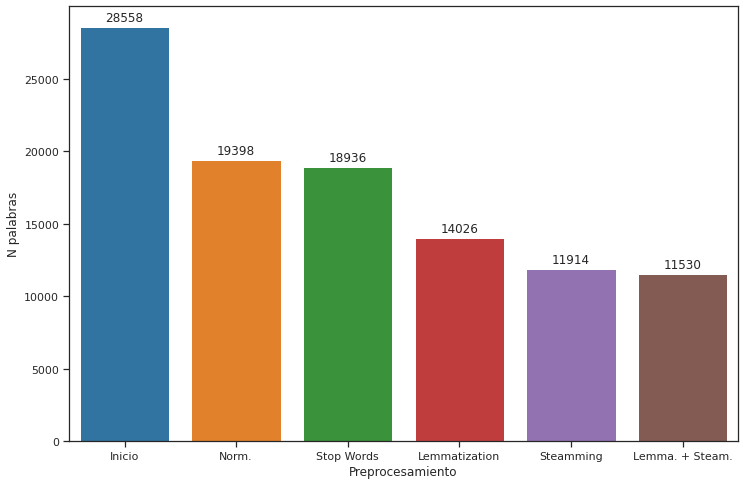

In [44]:
# https://datavizpyr.com/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/

fig, ax = plt.subplots(figsize=(12, 8))
splot = sns.barplot(x="Preprocesamiento", y="N palabras", data=df_count, ax=ax)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

Eligimos combinación (Norm. + SW + Stemming) es la manera más equilibrada en cuanto a rendimiento y cantidad de vocabulario que reducimos. Descartamos por tanto aplicar Lemma.

Nos queamos con un vocabulario de 8491

## Sin text augmentation

In [118]:
X = df.drop(columns=['like'])
y = df['like'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y, random_state=10)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=15/90, stratify=y_train, random_state=10) 

X_train = X_train['overview']
X_test = X_test['overview']
X_val = X_val['overview']

In [119]:
X_test.head(5)

802    juli nobl pierc brosn asesin sueld viv profund...
288    cuart ano hogwarts harry enfrent desafi peligr...
884    millon nin mund santiag suen jugador futbol pr...
115    nin orfanat pas tant hambr desesper decid habl...
634    isabell rees witherspoon espos ingenier quimic...
Name: overview, dtype: object

In [120]:
len(X_train)

1531

In [121]:
vectorizer = CountVectorizer(stop_words=stop_words)
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)
X_val = vectorizer.transform(X_val)

In [110]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

input_dim = X_train.shape[1]  # Number of features

# Test with Sequential Model 

model = Sequential()
model.add(layers.Dense(15, input_dim=input_dim, 
                       activation='relu',
                       name='dense_1'))
model.add(layers.Dense(1, activation='sigmoid', name='dense_2'))

In [111]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 15)                152850    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 16        
Total params: 152,866
Trainable params: 152,866
Non-trainable params: 0
_________________________________________________________________


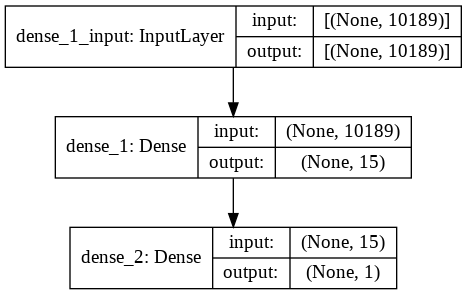

In [114]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [112]:
epochs = 8
batch_size = 4

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    verbose=True,
                    validation_data=(X_val, y_val),
                    batch_size=batch_size)

Epoch 1/8
383/383 [==============================] - 1s 2ms/step - loss: 0.6857 - accuracy: 0.5837 - val_loss: 0.6606 - val_accuracy: 0.7362
Epoch 2/8
383/383 [==============================] - 1s 2ms/step - loss: 0.6257 - accuracy: 0.8290 - val_loss: 0.6087 - val_accuracy: 0.7850
Epoch 3/8
383/383 [==============================] - 1s 2ms/step - loss: 0.5399 - accuracy: 0.8813 - val_loss: 0.5557 - val_accuracy: 0.8078
Epoch 4/8
383/383 [==============================] - 1s 2ms/step - loss: 0.4407 - accuracy: 0.9392 - val_loss: 0.5117 - val_accuracy: 0.8176
Epoch 5/8
383/383 [==============================] - 1s 2ms/step - loss: 0.3697 - accuracy: 0.9373 - val_loss: 0.4791 - val_accuracy: 0.8208
Epoch 6/8
383/383 [==============================] - 1s 2ms/step - loss: 0.3001 - accuracy: 0.9593 - val_loss: 0.4551 - val_accuracy: 0.8241
Epoch 7/8
383/383 [==============================] - 1s 2ms/step - loss: 0.2494 - accuracy: 0.9738 - val_loss: 0.4372 - val_accuracy: 0.8241
Epoch 8/8
383

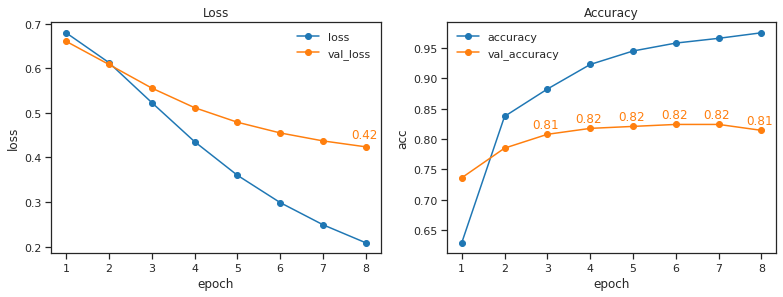

In [113]:
#Plot history

fit_history = pd.DataFrame(history.history)
fit_history['epoch'] = fit_history.index + 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.25))

# Loss
fit_history.plot(x='epoch', y=['loss', 'val_loss'], kind='line', ylabel='loss', title='Loss', marker='o', ax=ax1)
# label points on the plot only if they are less than 0.43
for x, y in zip(fit_history['epoch'], fit_history['val_loss']):
  if y <0.43:
   ax1.text(x = x - 0.35, # x-coordinate position of data label
            y = y + 0.02, # y-coordinate position of data label, adjusted to be 150 below the data point
            s = '{:.2f}'.format(y), # data label, formatted to ignore decimals
            color = 'tab:orange') # set colour of line

# Acc
fit_history.plot(x='epoch', y=['accuracy', 'val_accuracy'], kind='line', ylabel='acc', title='Accuracy', marker='o', ax=ax2)
for x, y in zip(fit_history['epoch'], fit_history['val_accuracy']):
  if y >0.80:
   ax2.text(x = x - 0.35, # x-coordinate position of data label
            y = y + 0.01, # y-coordinate position of data label, adjusted to be 150 below the data point
            s = '{:.2f}'.format(y), # data label, formatted to ignore decimals
            color = 'tab:orange') # set colour of line

In [124]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score

y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_true = y_test

print('Acc: ' + str(accuracy_score(y_true, y_pred).round(4)))
print('Precision: ' + str(precision_score(y_true, y_pred).round(4)))
print('Recall: ' + str(recall_score(y_true, y_pred).round(4)))
print('F1: ' + str(f1_score(y_true, y_pred).round(4)))
print('Conf. Matrix: ')
print(confusion_matrix(y_true, y_pred))

Acc: 0.7951
Precision: 0.8228
Recall: 0.6989
F1: 0.7558
Conf. Matrix: 
[[98 14]
 [28 65]]


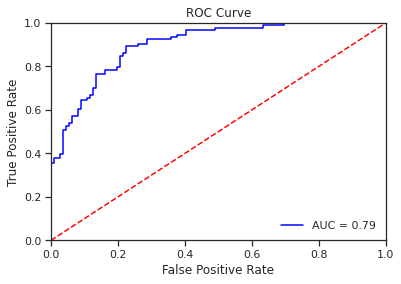

AUC: 0.787


In [125]:
y_pred_keras = model.predict(X_test).flatten()
fpr, tpr, thresholds = roc_curve(y_true, y_pred_keras)
roc_auc = roc_auc_score(y_true, y_pred)

def plot_roc_curve(fpr,tpr): 
  plt.title('ROC Curve')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()   
  
plot_roc_curve(fpr,tpr) 
print('AUC: ' + str(roc_auc.round(4)))

## Con text augmentation

In [126]:
X = df.drop(columns=['like'])
y = df['like']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y, random_state=10)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=15/90, stratify=y_train, random_state=10) 

X_test = X_test['overview']
y_test = y_test.values

X_val = X_val['overview']
y_val = y_val.values

In [127]:
X_test.head(5)

802    juli nobl pierc brosn asesin sueld viv profund...
288    cuart ano hogwarts harry enfrent desafi peligr...
884    millon nin mund santiag suen jugador futbol pr...
115    nin orfanat pas tant hambr desesper decid habl...
634    isabell rees witherspoon espos ingenier quimic...
Name: overview, dtype: object

In [128]:
X_train_new = X_train['overview'].copy()
y_train_new = y_train.copy()

for i in range(0, len(X_train)):
  new_series_X = pd.Series(X_train.iloc[i]['new_overviews'])
  X_train_new = X_train_new.append(new_series_X, ignore_index=True)

  y_value = y_train.iloc[i]
  new_series_y = pd.Series([y_value, y_value])
  y_train_new = y_train_new.append(new_series_y, ignore_index=True)

y_train_new = y_train_new.values

In [129]:
# Count
corpus_augment = ""
for i in range(0, len(df)):
  corpus_augment = corpus_augment + " ".join(df.iloc[i]['new_overviews'])

full_corpus = " ".join(df['overview']) + "" + corpus_augment
augm_n_words = len(Counter(full_corpus.split()))
augm_n_words

15863

In [130]:
vectorizer = CountVectorizer(stop_words=stop_words)
vectorizer.fit(X_train_new)
X_train_new = vectorizer.transform(X_train_new)
X_test  = vectorizer.transform(X_test)
X_val  = vectorizer.transform(X_val)

In [200]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

input_dim = X_train_new.shape[1]  # Number of features

# Test with Sequential Model 

model = Sequential()
model.add(layers.Dense(15, input_dim=input_dim, 
                       activation='relu',
                       name='dense_1'))
model.add(layers.Dense(1, activation='sigmoid', name='dense_2'))

In [201]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 15)                180795    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 16        
Total params: 180,811
Trainable params: 180,811
Non-trainable params: 0
_________________________________________________________________


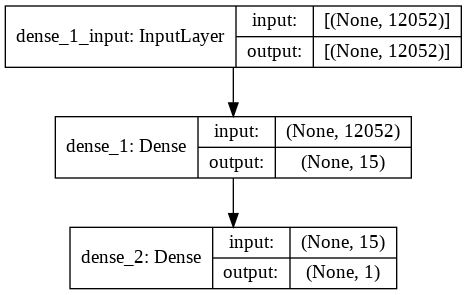

In [202]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [203]:
X_train_new.shape[0] / X_train.shape[0]

3.0

Al tener 3 veces más datos podemos tener un batch_size superior en esta caso pasamos a 12

In [204]:
epochs = 8
batch_size = 8

history = model.fit(X_train_new, y_train_new,
                    epochs=epochs,
                    verbose=True,
                    validation_data=(X_val, y_val),
                    batch_size=batch_size)

Epoch 1/8
575/575 [==============================] - 2s 2ms/step - loss: 0.6706 - accuracy: 0.6378 - val_loss: 0.6113 - val_accuracy: 0.7655
Epoch 2/8
575/575 [==============================] - 1s 2ms/step - loss: 0.5184 - accuracy: 0.8733 - val_loss: 0.5185 - val_accuracy: 0.8111
Epoch 3/8
575/575 [==============================] - 1s 2ms/step - loss: 0.3571 - accuracy: 0.9636 - val_loss: 0.4628 - val_accuracy: 0.8274
Epoch 4/8
575/575 [==============================] - 1s 2ms/step - loss: 0.2555 - accuracy: 0.9791 - val_loss: 0.4310 - val_accuracy: 0.8143
Epoch 5/8
575/575 [==============================] - 1s 2ms/step - loss: 0.1841 - accuracy: 0.9876 - val_loss: 0.4146 - val_accuracy: 0.8111
Epoch 6/8
575/575 [==============================] - 1s 2ms/step - loss: 0.1329 - accuracy: 0.9962 - val_loss: 0.4065 - val_accuracy: 0.8111
Epoch 7/8
575/575 [==============================] - 1s 2ms/step - loss: 0.0977 - accuracy: 0.9984 - val_loss: 0.4043 - val_accuracy: 0.8078
Epoch 8/8
575

https://stats.stackexchange.com/questions/258166/good-accuracy-despite-high-loss-value

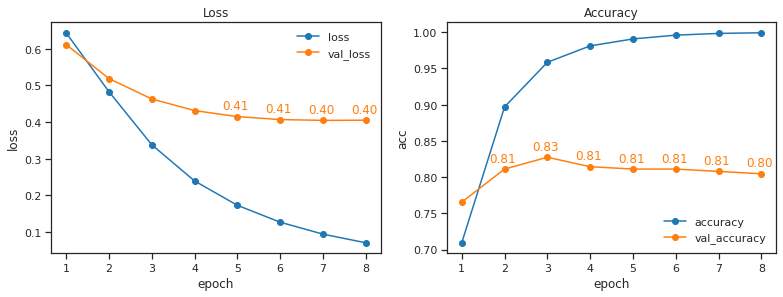

In [205]:
#Plot history

fit_history = pd.DataFrame(history.history)
fit_history['epoch'] = fit_history.index + 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.25))

# Loss
fit_history.plot(x='epoch', y=['loss', 'val_loss'], kind='line', ylabel='loss', title='Loss', marker='o', ax=ax1)
# label points on the plot only if they are less than 0.43
for x, y in zip(fit_history['epoch'], fit_history['val_loss']):
  if y <0.43:
   ax1.text(x = x - 0.35, # x-coordinate position of data label
            y = y + 0.02, # y-coordinate position of data label, adjusted to be 150 below the data point
            s = '{:.2f}'.format(y), # data label, formatted to ignore decimals
            color = 'tab:orange') # set colour of line

# Acc
fit_history.plot(x='epoch', y=['accuracy', 'val_accuracy'], kind='line', ylabel='acc', title='Accuracy', marker='o', ax=ax2)
for x, y in zip(fit_history['epoch'], fit_history['val_accuracy']):
  if y >0.80:
   ax2.text(x = x - 0.35, # x-coordinate position of data label
            y = y + 0.01, # y-coordinate position of data label, adjusted to be 150 below the data point
            s = '{:.2f}'.format(y), # data label, formatted to ignore decimals
            color = 'tab:orange') # set colour of line

In [206]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score

y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_true = y_test

print('Acc: ' + str(accuracy_score(y_true, y_pred).round(4)))
print('Precision: ' + str(precision_score(y_true, y_pred).round(4)))
print('Recall: ' + str(recall_score(y_true, y_pred).round(4)))
print('F1: ' + str(f1_score(y_true, y_pred).round(4)))
print('Conf. Matrix: ')
print(confusion_matrix(y_true, y_pred))

Acc: 0.8146
Precision: 0.8313
Recall: 0.7419
F1: 0.7841
Conf. Matrix: 
[[98 14]
 [24 69]]


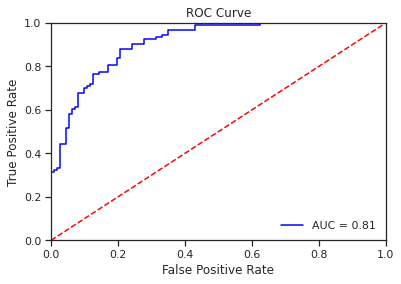

AUC: 0.8085


In [207]:
y_pred_keras = model.predict(X_test).flatten()
fpr, tpr, thresholds = roc_curve(y_true, y_pred_keras)
roc_auc = roc_auc_score(y_true, y_pred)

def plot_roc_curve(fpr,tpr): 
  plt.title('ROC Curve')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()   
  
plot_roc_curve(fpr,tpr) 
print('AUC: ' + str(roc_auc.round(4)))

In [208]:
step = ['Inicio', 'Norm. + S.W. + Steam.', 'Text Aug.']
n_words = [ini_n_words, stemming_n_words, augm_n_words]

data_count = {
    'Preprocesamiento': step,
    'N palabras': n_words
}

df_count = pd.DataFrame(data=data_count)

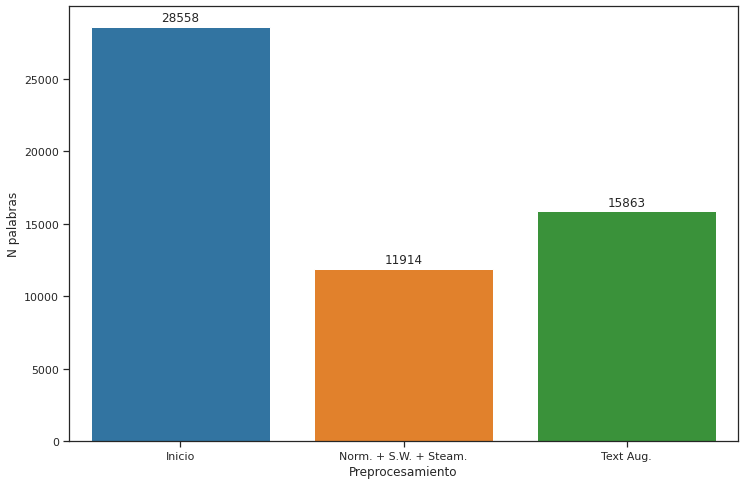

In [209]:
fig, ax = plt.subplots(figsize=(12, 8))
splot = sns.barplot(x="Preprocesamiento", y="N palabras", data=df_count, ax=ax)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')